## 2- Trial by Trial Data

Much of what we went over in the first notebook was information for a whole session, or day. But, most of our analyses depend on trial by trial information. In this notebook I'll show you how to access to types of trial information from DJ- **parsed events history** and **protocol data**.

Written by Jess Breda Feburary 2023

### 1. Libararies

In [3]:
import datajoint as dj
dj.blob.use_32bit_dims = True # need this for peh and pd!
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("talk")

%load_ext autoreload
%autoreload 2

### 2. Parsed Events History

**What is it?** 

Parsed events history (peh) is where all the event timing information for each trial in a session stored. This includes animal actions (poke times) as well as protocol actions (state times, waves). 

**How is it stored?**

In it's native format, it is a series of nested matlab structs. When read into python in this way, it's a nested list of lists of dictionaries. 

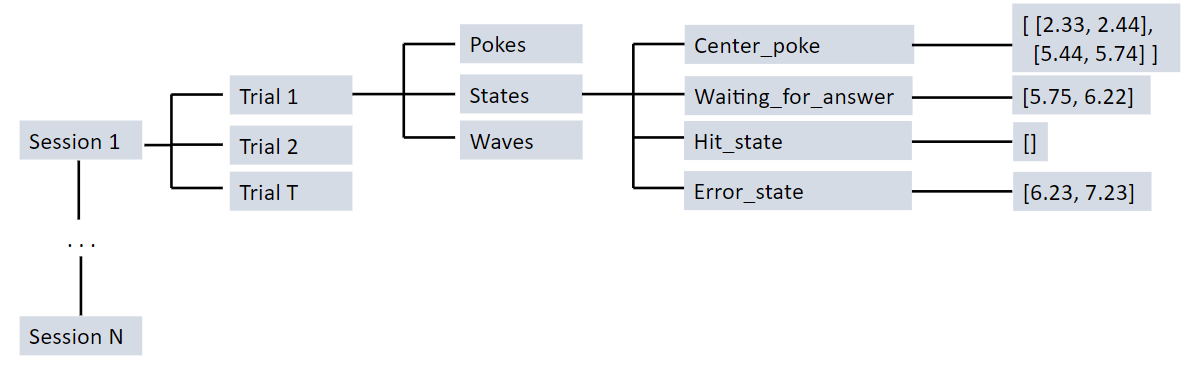

**Why is this sub optimal?**

(1) access nested structures in python is a pain

(2) it's *extremely* slow to read in on DataJoint

**What's the fix?**

The `BehaviorEvent` table which takes (almost) all of the peh info and turns it into a long form pandas DataFrame which is pre-formatted reads and in 5x faster.

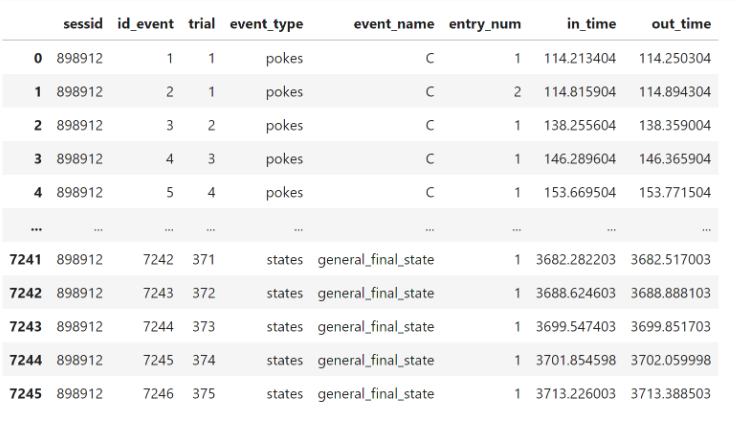


#### 2.1 Read in 

Let's read in the events table for a single session and play around with it.

In [4]:
# __name__ =                    (__name__, schema name)
bdata = dj.create_virtual_module("bdata", "bdata")

print(bdata.BehaviorEvent.describe())

[2023-02-20 17:15:57,649][INFO]: Connecting jbreda@bdata00.pni.princeton.edu:3306
[2023-02-20 17:15:58,166][INFO]: Connected jbreda@bdata00.pni.princeton.edu:3306


-> bdata.Sessions
id_event             : int                          # Unique number for event
---
trial                : int                          # trial number in session
event_type           : varchar(16)                  # type of event in session (e.g. pokes, states)
event_name           : varchar(32)                  # sub category of event type (e.g. C, L, R, state0)
entry_num            : int                          # occurence number of event inside trial
in_time=null         : double                       # start time of event
out_time=null        : double                       # end time of event



In [5]:
SESSION = 898912
key = {'sessid' : SESSION}

df_events = pd.DataFrame((bdata.BehaviorEvent & key).fetch(as_dict=True))

df_events

,sessid,id_event,trial,event_type,event_name,entry_num,in_time,out_time
0,898912,1,1,pokes,C,1,114.213404,114.250304
1,898912,2,1,pokes,C,2,114.815904,114.894304
2,898912,3,2,pokes,C,1,138.255604,138.359004
3,898912,4,3,pokes,C,1,146.289604,146.365904
4,898912,5,4,pokes,C,1,153.669504,153.771504
...,...,...,...,...,...,...,...,...
7241,898912,7242,371,states,general_final_state,1,3682.282203,3682.517003
7242,898912,7243,372,states,general_final_state,1,3688.624603,3688.888103
7243,898912,7244,373,states,general_final_state,1,3699.547403,3699.851703
7244,898912,7245,374,states,general_final_state,1,3701.854598,3702.059998


#### 2.2 Example Usage- Trial Duration

Here is a simple example of how you could use the events table. We are going to plot the trial duration across a session for an animal.

First, we will calculate the trial duration by using entries and exits from `state_0`. Every trial has two entries into `state_0` with this format: `[NaN, t_start], [t_end, NaN]`

In [7]:
# filter date frame for easier iteration
state_0_events = df_events.query("event_name == 'state_0'")

# initialize
n_trials = state_0_events.trial.max()  # 0 index offset
t_durs = np.zeros((n_trials))

# use group by to iterate via the trials column
for n_trial, sub_df in state_0_events.groupby("trial"):

    t_start = sub_df.out_time.max()
    t_end = sub_df.in_time.max()
    t_dur = t_end - t_start

    assert t_dur > 0, f"negative trial duration on trial {n_trial}"

    t_durs[n_trial - 1] = t_dur  # 0 index offset

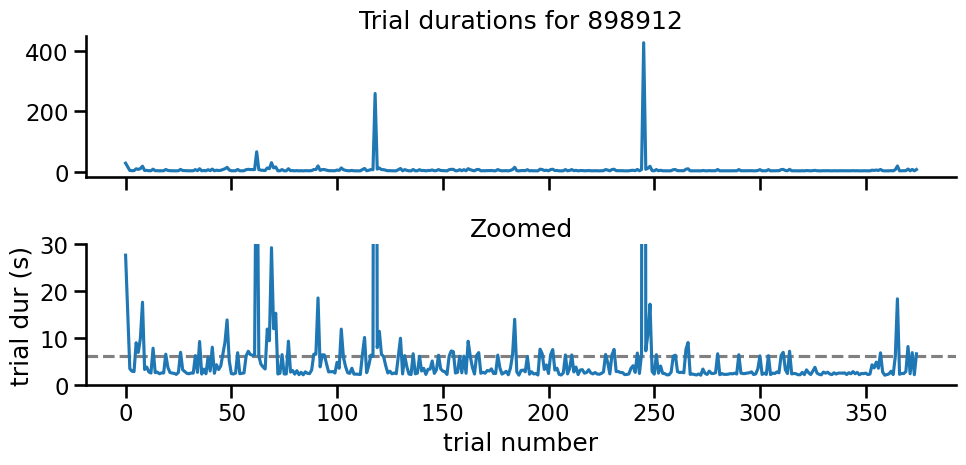

In [8]:
# plot 
fig, ax = plt.subplots(2, 1, figsize=(10,5), sharex=True)

ax[0].plot(np.arange(n_trials), t_durs)
ax[1].plot(np.arange(n_trials), t_durs)
ax[1].axhline(np.mean(t_durs), color="gray", linestyle="--", zorder=1)

# aesthetics
ax[0].set(title=f"Trial durations for {SESSION}")
ax[1].set(ylabel="trial dur (s)", xlabel="trial number", ylim=(0, 30), title="Zoomed")

sns.despine()
plt.tight_layout()

Looks like I might want to check out the video and see if the large pause around trial 250 was due to the animal taking a long break or a bpod freeze &#x1F644;. 

#### 2.3 Example usage- pokes in a session

Here's an example of how to look at the number of pokes over time in a session. I've zoomed in on the first 500 seconds of the session for ease of viewing. This could be upgraded by adding in trial markers, coloring the pokes depending on the type of trial that occurred, etc. 

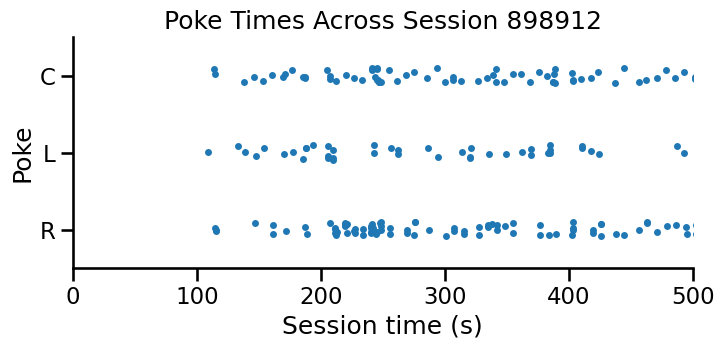

In [105]:
# make a dataframe with only the poke events
poke_events_df = df_events.query("event_type == 'pokes'")

fig,ax = plt.subplots(figsize=(8,3))

sns.stripplot(data=poke_events_df, x="in_time", y="event_name", ax=ax)
plt.xlim(0,500)

ax.set(xlabel = "Session time (s)", ylabel = "Poke", title=f"Poke Times Across Session {SESSION}")
sns.despine()

Another thing you could do is plot poke information on a trial level. For example, what is the distribution of left, center and right pokes per trial? 

This is where the magic of `pandas` really shines. You can use the `groupby` command and one line of code to summarize information condition on multiple variables. printing the `trial_poke_counts` will help give you some intuition.

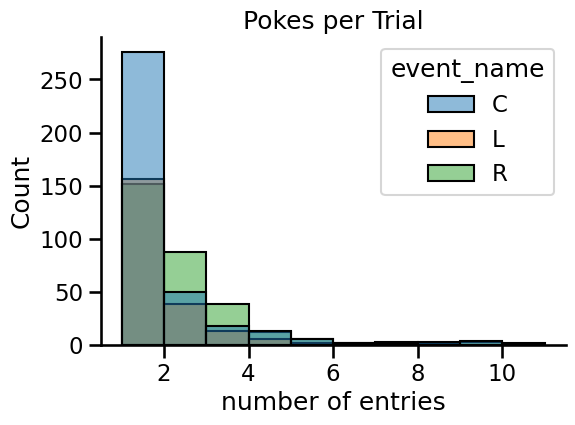

In [107]:
# calculate
trial_poke_counts = poke_events_df.groupby(["trial", "event_name"]).entry_num.max()

# plot
fig, ax = plt.subplots(figsize=(6,4))

sns.histplot(data=trial_poke_counts.reset_index(), x="entry_num",hue='event_name',binwidth=1)

# aesthetics
ax.set(xlabel="number of entries", title="Pokes per Trial")
sns.despine()

This plot is okay, but because there is such little variance in the data, plotting the pokes on top of each other is limiting. Let's use the power of `groupby` and have one plot for each poke type.

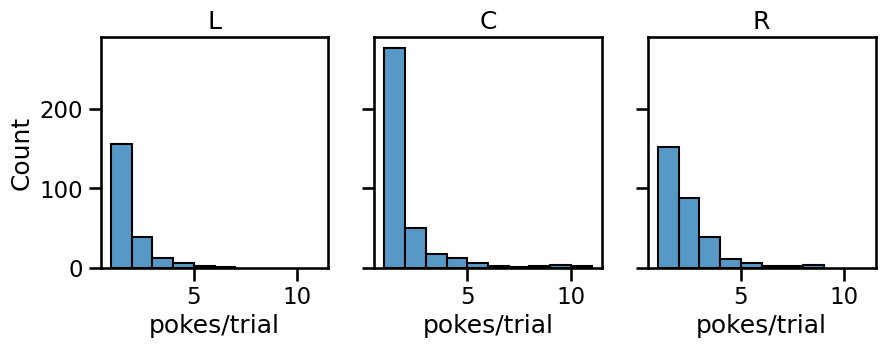

In [108]:
from performance_plots import set_poke_axis

fig,ax = plt.subplots(1,3, figsize=(10,3), sharey=True, sharex=True)

# this iterates over event_names ("L", "C", "R")
# and allows you to access the `poke_df` that only
# contains info with the corresponding event name
for poke, poke_df in poke_events_df.groupby("event_name"):
     
     # calculate max number of event_name pokes on each trial
    trial_poke_counts = poke_df.groupby("trial").entry_num.max()
    
    # plot
    iax = set_poke_axis(poke) # orients plot L-C-R
    sns.histplot(trial_poke_counts,binwidth=1, ax=ax[iax])

    # aesthetics 
    ax[iax].set(title=f"{poke}", xlabel="pokes/trial")


Hopefully this gave you an idea of how this table can be used with `pandas` to plot animal data.

Some other ideas of things you can track using `BehaviorEvent` are:
 * stimulus timing (via wave info)
 * time to violation
 * average time from center -> side
 * alignment between phys & behavior.

### Protocol Data

Protocol Data (pd) is a field in the `bdata.Sessions` table. It's usually created under the `make_and_send_summary` case of the protocol and depending on the protocol you will find differing information.

I leverage this field in the [`DMS` protocol](https://github.com/Brody-Lab/Protocols/blob/master/%40DMS/HistorySection.m#L429) to save out trial-by-trial information so I can access it all via DataJoint (rather than opening a `_data.mat` file for each session). I highly recommend it and am happy to talk about how to adjust your protocol to do so. 

| variable             | values          | key                                                 |
|----------------------|-----------------|-----------------------------------------------------|
| `hit_history`        | [0, 1, NaN]     | [error, hit, violation]                             |
| `temp_error_history` | [0, 1, NaN]     | [no terror, terror, violation]                      |
| `side_history`       | [l, r]          | [left, right]                                       |
| `result_history`     | [1, 2, 3, 4, 5] | [hit, error, violation, terror, crash]              |
| `sa`                 | float           | value of sa in Hz                                   |
| `sb`                 | float           | value of sb in Hz                                   |
| `dms_type`           | [0, 1]          | [nonmatch, match]                                   |
| `delay`              | float           | duration of delay between sa/sb in s                |
| `fixation`           | float           | duration of pre --> go (fixation required or not)   |
| `timeouts`           | float           | duration of timeout in s                            |
| `helper`             | [0, 1]          | if trial was in helper block (not in use currently) |
| `stage`              | float           | stage number                                        |


#### 3.1 Read in

Let's go through the steps of reading in these data for the same session as above and in the next notebook I'll have some code for how I automate & customize this process for my protocol.



In [9]:
bdata = dj.create_virtual_module("bdata", "bdata")

key = {'sessid': SESSION}

protocol_data_blob = (bdata.Sessions & key).fetch('protocol_data', as_dict=True)

type(protocol_data_blob[0]['protocol_data'])

datajoint.blob.MatStruct

We can't directly read this in as a pandas DataFrame because it's a blob. To be honest, I don't exactly know what blobs are, but I do know that python doesn't really like them. So we need to use some `utility functions to go from **blob -> dict**.

In [10]:
from dj_utils import transform_blob

protocol_data_dict = transform_blob(protocol_data_blob[0]['protocol_data'])

for key,value in protocol_data_dict.items():
    print(f"key: {key} **** entries: {len(value)}")


key: hits **** entries: 375
key: temperror **** entries: 375
key: sides **** entries: 375
key: result **** entries: 375
key: sa **** entries: 375
key: sb **** entries: 375
key: dms_type **** entries: 375
key: delay **** entries: 375
key: fixation **** entries: 375
key: timeouts **** entries: 375
key: helper **** entries: 375
key: stage **** entries: 375


In [11]:
protocol_data_dict.keys()

dict_keys(['hits', 'temperror', 'sides', 'result', 'sa', 'sb', 'dms_type', 'delay', 'fixation', 'timeouts', 'helper', 'stage'])

Because all of the items in my DMS protocol data are the same length, I will then convert **dict -> DataFrame**.

In [12]:
from dj_utils import blob_dict_to_df

protocol_df = blob_dict_to_df(protocol_data_dict)

protocol_df

,hits,temperror,sides,result,sa,sb,dms_type,delay,fixation,timeouts,helper,stage
0,1.0,0.0,r,1.0,12000.0,3000.0,0.0,0.2,0.95,NaN,0.0,8.0
1,1.0,0.0,l,1.0,12000.0,12000.0,1.0,0.2,0.95,NaN,0.0,8.0
2,1.0,0.0,l,1.0,12000.0,12000.0,1.0,0.2,0.95,NaN,0.0,8.0
3,1.0,0.0,l,1.0,12000.0,12000.0,1.0,0.2,0.95,NaN,0.0,8.0
4,1.0,0.0,r,1.0,12000.0,3000.0,0.0,0.2,0.95,NaN,0.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...
370,1.0,0.0,l,1.0,12000.0,12000.0,1.0,0.2,0.95,NaN,0.0,8.0
371,1.0,0.0,r,1.0,12000.0,3000.0,0.0,0.2,0.95,NaN,0.0,8.0
372,0.0,0.0,r,2.0,12000.0,3000.0,0.0,0.2,0.95,5.0,0.0,8.0
373,1.0,0.0,r,1.0,12000.0,3000.0,0.0,0.2,0.95,NaN,0.0,8.0


One limitation of this approach that it doesn't do a great job of preserving data types. For example, `hits` is a `float`, but it should be an `int` (either the animal got it correct or not).

To this end, I've written some extra functions to clean up this import and append additional columns that can be found in `pd_to_df.py`. Let's check this out in the next notebook.